In [93]:
# Author: Nathan Jansen, jansenn1@msu.edu
#
# Description: A Qiskit program to run entangled cat states using IBM's publicly accessible quantum compters
#              and calculate the Shannon Entropy of the resulting runs. After run, calculates the entropies, 
#              plots data & linear fit.
#
# Revision History: Initial version, 06/30/2021
#                   Added calulations and plotting, 11/16/2021
#
# Notes:  Must have an IBMQ account, Qiskit's youtube has tutorials on setting one up
#---------------------------------------------------------------------------------------------------------

from qiskit import *
import numpy as np
from qiskit.visualization import plot_circuit_layout
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.ticker as ticker
IBMQ.load_account()


ibmqfactory.load_account:WARNING:2022-06-24 10:48:50,683: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [94]:
# Setting up the circuits

n = 2  # number of qubits
cat_circs = [];
for i in range(6):
    cat = QuantumCircuit(n);
    # Apply H gates
    
    cat.h(0);
    
    # Adding CNOT
    
    cat.cx(range(n-1),range(1,n));
    
    cat_circs.append(cat);
    n = n + 1


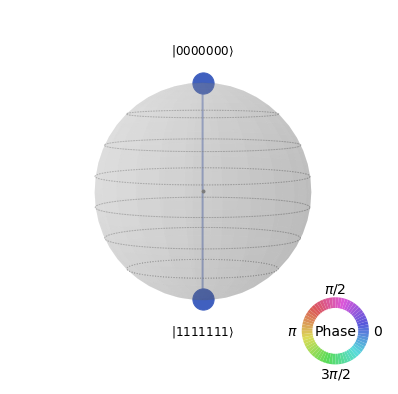

In [96]:
# This part checks if Qiskit is interpreting the cat state correctly by plotting the Bloch Sphere

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere

backend = BasicAer.get_backend('statevector_simulator')      # statevector simulator is the backend
result = execute(cat, backend).result()                      # Run the circuit on the backend
psi  = result.get_statevector(cat)                           # Declare results as Psi

# Plotting the Bloch sphere
plot_state_qsphere(psi)


In [97]:
#Adding measurements, you must add measurements after Bloch Sphere

for cat in cat_circs:
    cat.measure_all();


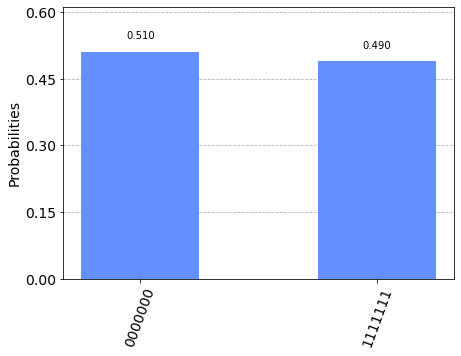

In [99]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(cat, backend = simulator, shots = 1024).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [100]:
# Making the list of circuits

qc_list=[];


for cat in cat_circs:
    dummylist = []
    for i in range(0,25):
        dummylist.append(cat);
    qc_list.append(dummylist);


In [104]:
# Run the job on quantum computer

provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibm_nairobi')  
       

job1 = execute(qc_list[0], backend=backend, shots = 1024)
job2 = execute(qc_list[1], backend=backend, shots = 1024)
job3 = execute(qc_list[2], backend=backend, shots = 1024)
job4 = execute(qc_list[3], backend=backend, shots = 1024)



In [46]:
# Monitoring the job, queue status/postion, and when completed
from qiskit.tools.monitor import job_monitor

job_monitor(job1)
job_monitor(job2)
job_monitor(job3)
job_monitor(job4)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [35]:
def entropy(p,s): # Defining the function that calculates the Entropy
    if p == 0:
        a = 0
        
    else:
        a = -p/s*np.log2(p/s)
    return float(a)

In [36]:
results = [job1.result(),job2.result(),job3.result(),job4.result()]

In [37]:
# Grab job counts and places them in an array in binary order

cnts = [] # list to hold the set of counts for each job

qn = 2

for result in results:
    nqbit = qn   
    n = 2**nqbit        
    vec = np.zeros(n)   #array for counts
    
    data =[]
    
    count = result.get_counts()
    for i in count:
        for key,value in i.items():
            idx = 0
            for i,b in enumerate(reversed(key)):
                if b == '1':
                    idx += 2**i
            vec[idx] = value  
        data.append(vec)
        vec = np.zeros(n)
    cnts.append(data)  
    qn = qn + 1 


In [43]:
ent = []                           # List of averaged entropy
stdev = []                         # Standard deviation between runs
w = []
for job in cnts:
    circ = []                             # This will hold the entropies of each circuit/job
    for run in job:
        h=[]                          # This will hold the result of individual counts
        for count in run:
            h.append(entropy(count,1024))
        circ.append(np.sum(h))
    stdev.append(np.std(circ))
    ent.append(np.average(circ))
    w.append(1/(np.std(circ))**2)  # Weights for the fits

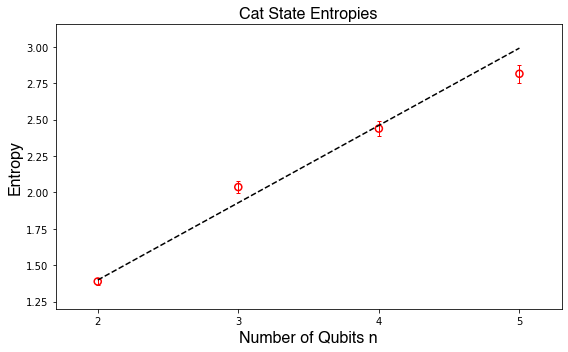

[0.53130453 0.33498566]


In [45]:
#----------------------------------------------------------------------------
#       Plotting the Data
#----------------------------------------------------------------------------

c

x = [2,3,4,5]
y = ent 

coef = np.polyfit(x,y,1, w = w )
poly1d_fn = np.poly1d(coef) 

plt.plot(x, poly1d_fn(x), '--k') 


plt.scatter(x, ent,s=50, marker = 'o', facecolors='none', edgecolors='r',linewidth=1.5)
plt.errorbar(x, ent,yerr = stdev,fmt=' ', ecolor='r',elinewidth=1,capsize=2, zorder=0)

    
plt.title('Cat State Entropies', fontsize=16, fontweight='bold', fontname = 'Helvetica')
plt.xlabel('Number of Qubits n', fontsize=16, fontname = 'Helvetica')
plt.ylabel('Entropy', fontsize=16, fontname = 'Helvetica')
plt.tight_layout() 

plt.show()


print(coef)  # slope and intercept
